In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print(f'Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0


In [2]:
import sys
sys.path.append("../")
import plot_utils

In [3]:
#making sure that tensorflow 'sees' the GPU device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14400517829488752251,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15485123218211108036
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9875649984
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4969064693332983000
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6945941789062656341
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
# loading the fashion mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

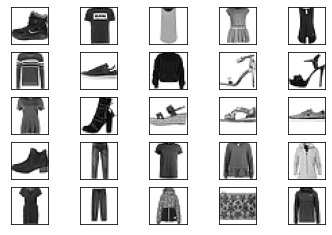

In [7]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [8]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [69]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5, 5), (2, 2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5, 5), (2, 2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5, 5), (2, 2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5, 5), (2,2), padding='same', activation='tanh')
])

TensorShape([1, 224, 224, 1])

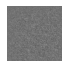

In [70]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image, 1)
generated_image.shape

In [62]:
generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 128)       409728    
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 128)     

In [58]:
generated_image.shape

TensorShape([1, 112, 112, 1])

In [63]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), (2,2), padding='same', input_shape=[224, 224, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (5, 5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5, 5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(512, (5, 5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [64]:
discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 112, 112, 32)      832       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)     

In [65]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49977848]], dtype=float32)>

In [66]:
discriminator.compile(loss=keras.losses.binary_crossentropy, optimizer='rmsprop')
discriminator.trainable = False
dc_gan = keras.models.Sequential([generator, discriminator])
dc_gan.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop())

In [67]:
# set the seed
seed = tf.random.normal(shape=[batch_size, 100])
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable= False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [68]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [29]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

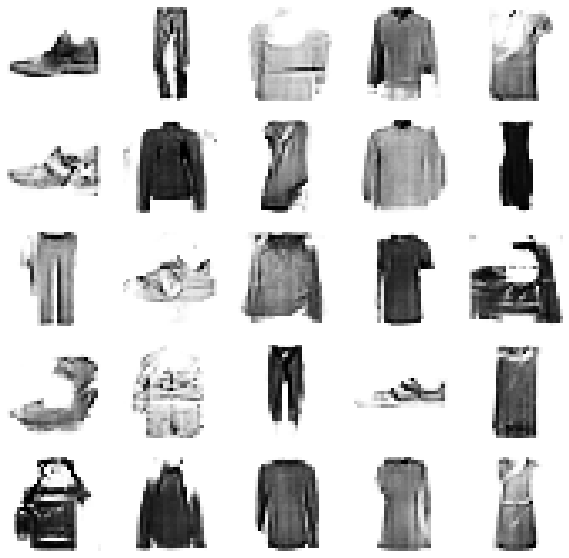

Wall time: 20min 14s


In [30]:
%%time
#with tf.device('/device:XLA_GPU:0'):
train_dcgan(dc_gan, dataset, batch_size, num_features, epochs=50)

In [31]:
dc_gan

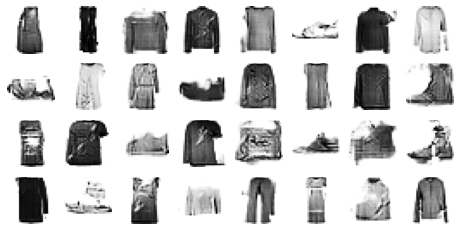

In [33]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

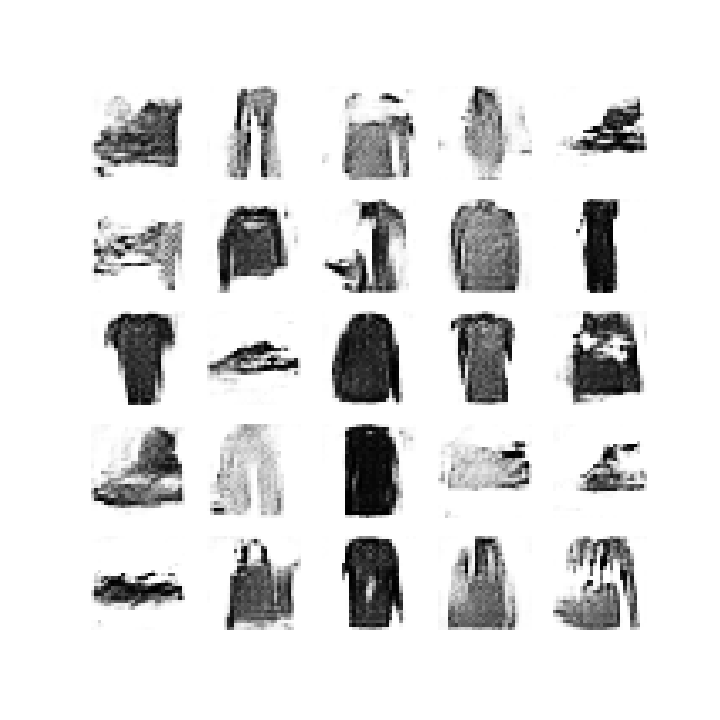

In [38]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame)> round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import IPython
display.Image(filename=anim_file)